## Project 2 - Time-series Prediction

Team Members: Vamshi Gujjari, Hemant Koti <br>

This project analyzes and predicts the trend in IBM's daily closing stock price value from 2000 to 2020. The IBM dataset is a multivariate time series data with columns containing stock values changing over time.<br>
Part I of the notebook will focus on visualization and providing metrics about the dataset required for training. <br>
Part II of the notebook uses classical time series forecasting methods (ARIMA, SARIMAX, VAR) to train and predict the closing stock price values for IBM. <br>
Part III of the notebook uses deep learning techniques (LSTM) to train and forecast the trends in the stock price value, i.e., whether the stock price goes up or down.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Part I: Prepare the dataset for training

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

from: can't read /var/mail/google.colab
/bin/bash: -c: line 0: syntax error near unexpected token `'/content/drive''
/bin/bash: -c: line 0: `drive.mount('/content/drive')'


In [ ]:
!ls 'drive/My Drive/Colab Notebooks'

IBM.csv  Pong-DQN.ipynb


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### 1. Choose the dataset

In [ ]:
ibm_stock_df = pd.read_csv('drive/My Drive/Colab Notebooks/IBM.csv', index_col='Date', parse_dates=True)
figsize = (15,10)
figsizeBig = (30,15)

In [ ]:
ibm_stock_df.shape

(14484, 6)

The actual dataset consists of 14484 entries. We observed increased variations in our model accuracy while training on old stock prices (the 1950s to 1990s). <br>
Hence we took only the last 20 years data (around 5k entries) to analyze the stock price trend.

In [ ]:
ibm_stock_df = ibm_stock_df.tail(5000)

In [ ]:
ibm_stock_df.shape

(5000, 6)

The following are the columns in the dataset
1. Open: The price of the stock at market open
2. High: Highest price reached in the day
3. Low: Lowest price reached in the day
4. Close: The closing price of the stock in the day
5. Adj Close: The closing price of the stock after adjustments for all applicable splits and dividend distributions
6. Volume: Number of shares traded

In [ ]:
ibm_stock_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
ibm_stock_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
ibm_stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-08-30,130.7500,131.5000,129.5625,130.312500,84.111313,4928800
2000-08-31,131.8750,134.1875,131.6250,132.015625,85.210609,5469500
2000-09-01,133.0625,134.9375,132.6250,133.625000,86.249390,5776300
2000-09-05,132.8125,133.3125,130.8125,131.187500,84.676140,4112100
2000-09-06,130.8750,134.8750,130.3750,131.437500,84.837471,6473000


In [ ]:
ibm_stock_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-10,115.500000,118.570000,115.290001,118.349998,118.349998,4285700
2020-07-13,119.779999,120.989998,118.660004,119.199997,119.199997,4650700
2020-07-14,118.620003,120.889999,117.919998,120.599998,120.599998,4534400
2020-07-15,122.400002,123.959999,122.150002,123.000000,123.000000,4473400
2020-07-16,122.680000,124.480003,122.160004,124.010002,124.010002,4329000


#### 2. Extract and describe the main statistics about the dataset and provide visual representation of the dataset.

In [ ]:
ibm_stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,129.906043,131.050240,128.848744,129.966104,99.508252,6.075628e+06
std,38.454546,38.526270,38.380232,38.460595,35.976719,3.310189e+06
min,54.650002,56.700001,54.009998,55.070000,35.962383,1.027500e+06
25%,93.946873,94.930626,93.000000,93.871250,63.038117,3.844025e+06
50%,126.875000,127.884998,125.864998,126.950001,94.106102,5.235100e+06
75%,159.720005,160.869999,158.647499,159.727501,133.677822,7.358425e+06
max,215.380005,215.899994,214.300003,215.800003,163.324295,4.120730e+07


As observed in the graph below, the given data is non-stationery with random upward and downward trends. The data represented is IBM's daily closing stock price value.

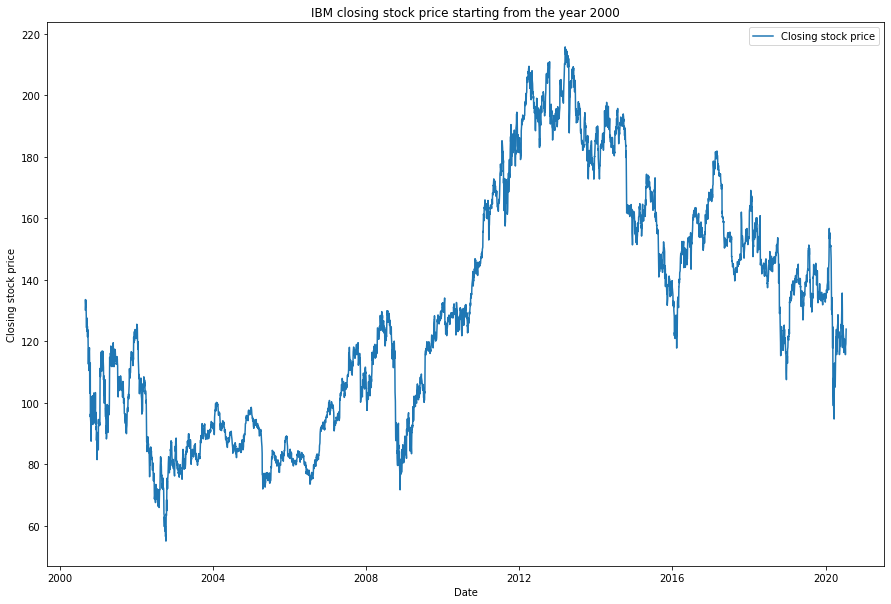

In [ ]:
plt.figure(figsize=figsize)
sns.lineplot(data=ibm_stock_df['Close'], label='Closing stock price')
plt.xlabel('Date')
plt.ylabel('Closing stock price')
plt.title('IBM closing stock price starting from the year 2000')
plt.legend()

The graph below shows the monthly trend for closing price of IBM stock data from 2000 to 2020.

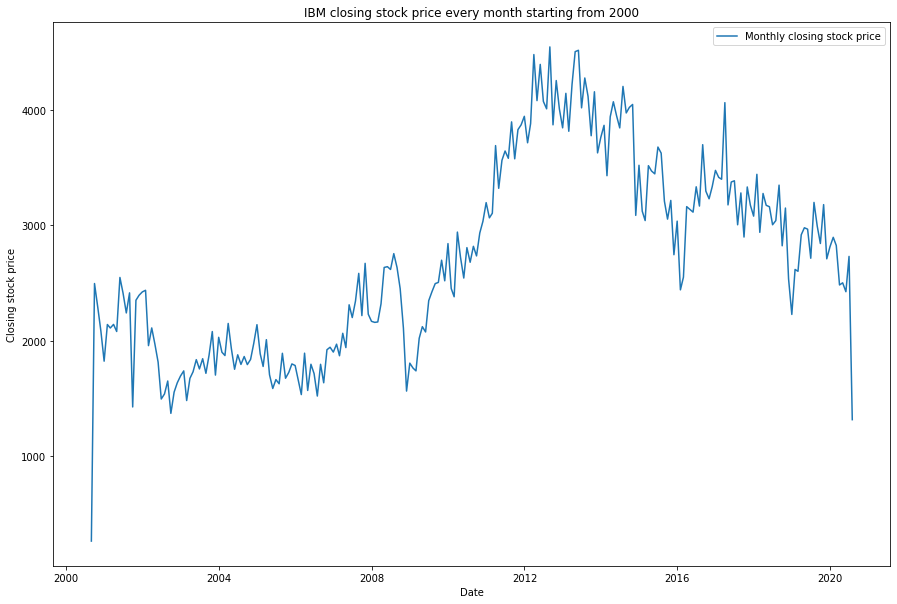

In [ ]:
plt.figure(figsize=figsize)
sns.lineplot(data=ibm_stock_df['Close'].resample('M').sum(), label='Monthly closing stock price')
plt.xlabel('Date')
plt.ylabel('Closing stock price')
plt.title('IBM closing stock price every month starting from 2000')
plt.legend()

As observed in the graph below, the given data is non-stationery with random upward and downward trends. The data represented is the number of shares traded for IBM each day.

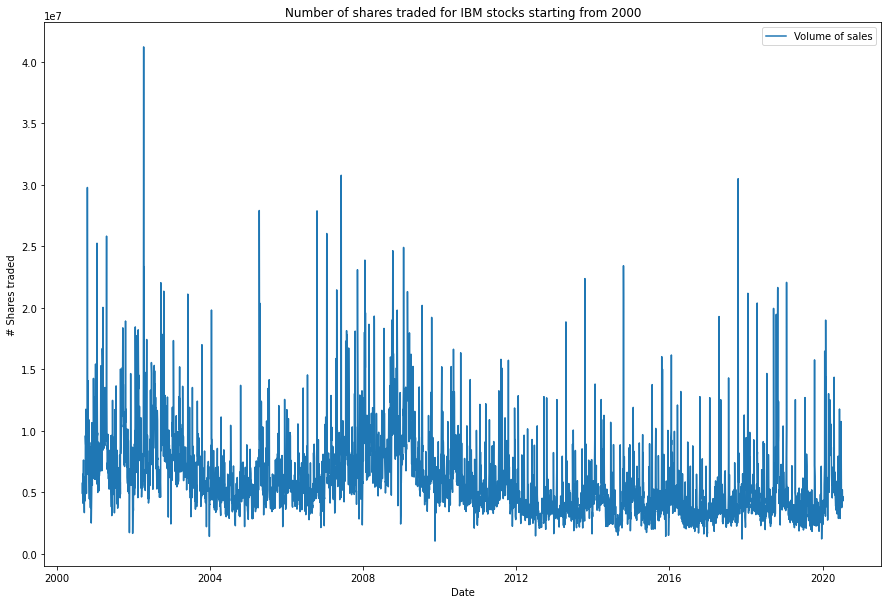

In [ ]:
plt.figure(figsize=figsize)
sns.lineplot(data=ibm_stock_df['Volume'], label='Volume of sales')
plt.xlabel('Date')
plt.ylabel('# Shares traded')
plt.title('Number of shares traded for IBM stocks starting from 2000')
plt.legend()

The graph below shows the monthly trend for number of shares traded, IBM stock data from 2000 to 2020.

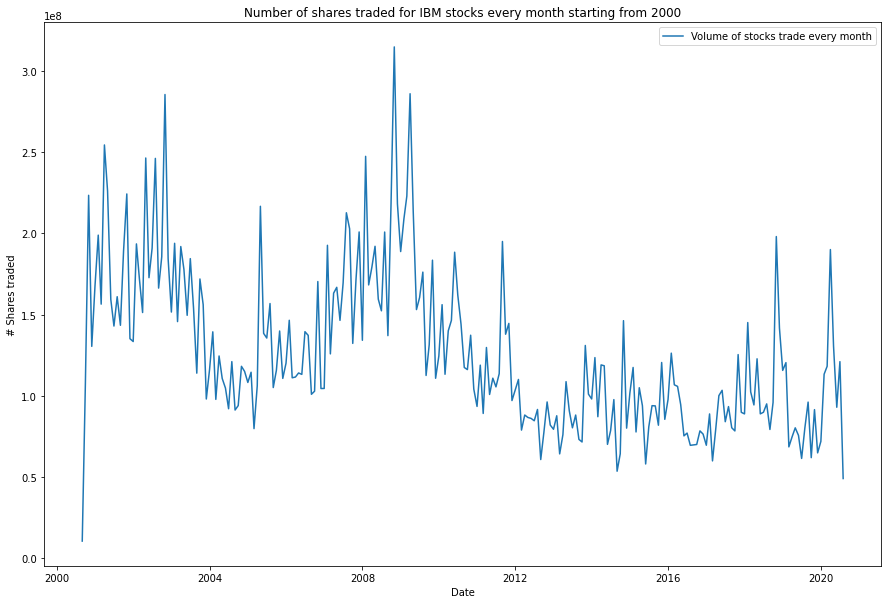

In [ ]:
plt.figure(figsize=figsize)
sns.lineplot(data=ibm_stock_df['Volume'].resample('M').sum(), label='Volume of stocks trade every month')
plt.xlabel('Date')
plt.ylabel('# Shares traded')
plt.title('Number of shares traded for IBM stocks every month starting from 2000')
plt.legend()

The lag plot below suggests the correlation measure in the dataset. A positive upward trend indicates a positive autocorrelation which can be verified in the ACF plot. <br>
We plot the graphs for lag values of 1, 5, 50, 100. As we increase the lag value, the randomness in the correlation increases. This suggests that values are correlated to recent values than past values.

Text(0.5, 1.0, 'IBM Autocorrelation plot (lag = 100)')

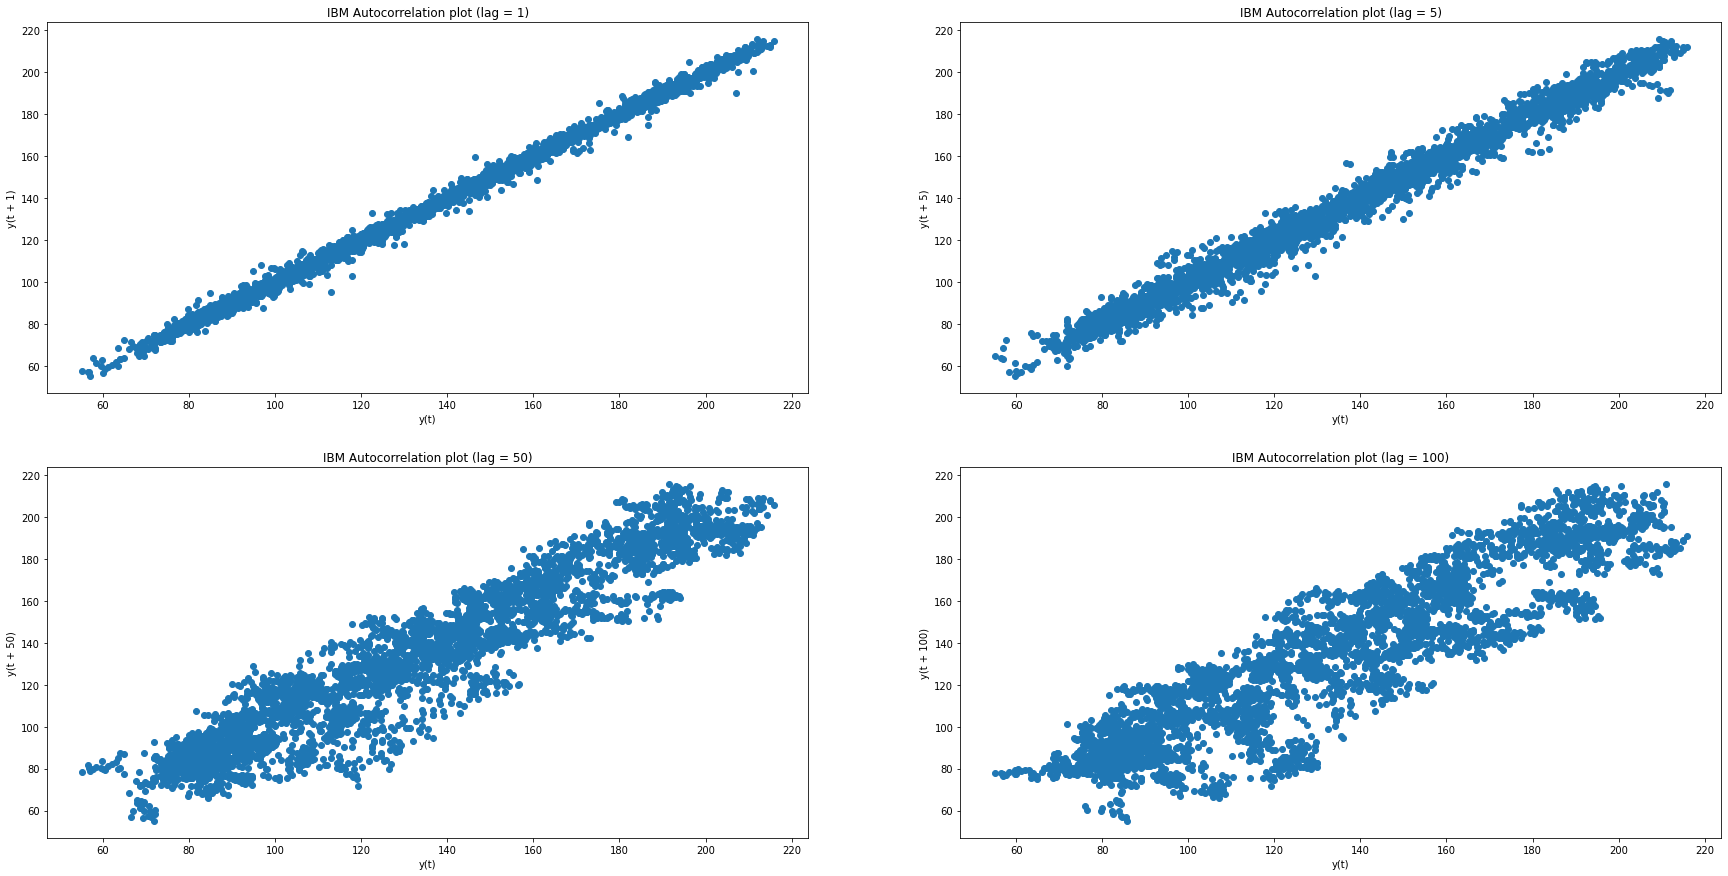

In [ ]:
fig = plt.figure(figsize=figsizeBig)
ax1 = fig.add_subplot(221)
lag_plot(ibm_stock_df['Close'], lag=1, ax=ax1)
plt.title('IBM Autocorrelation plot (lag = 1)')

ax2 = fig.add_subplot(222)
lag_plot(ibm_stock_df['Close'], lag=5, ax=ax2)
plt.title('IBM Autocorrelation plot (lag = 5)')

ax3 = fig.add_subplot(223)
lag_plot(ibm_stock_df['Close'], lag=50, ax=ax3)
plt.title('IBM Autocorrelation plot (lag = 50)')

ax4 = fig.add_subplot(224)
lag_plot(ibm_stock_df['Close'], lag=100, ax=ax4)
plt.title('IBM Autocorrelation plot (lag = 100)')

A difference d = 1 does not indicate any type of correlation for lag value 1. We can observe that the plot below is mostly randomized.

Text(0.5, 1.0, 'IBM Autocorrelation plot (d = 1, lag = 1)')

<Figure size 1080x720 with 0 Axes>

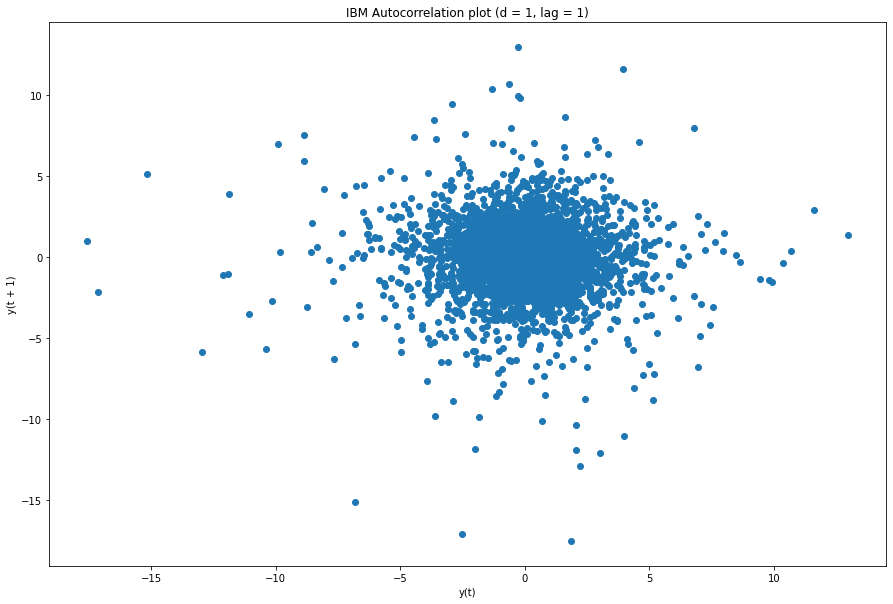

In [ ]:
fig = plt.figure(figsize=figsize)
plt.figure(figsize=figsize)
lag_plot((ibm_stock_df['Close'] - ibm_stock_df['Close'].shift(1)), lag=1)
plt.title('IBM Autocorrelation plot (d = 1, lag = 1)')

In [ ]:
# Code snippet taken from https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    """
    Function to test stationarity in time series data
    """

    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=figsizeBig)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
def non_stationary_plot(label):
  fig = plt.figure(figsize=figsizeBig)
  ax1 = fig.add_subplot(221)
  fig = sm.graphics.tsa.plot_acf(ibm_stock_df[label].iloc[13:], lags=1000, ax=ax1)
  plt.xlabel('Number of Lags (1000)')
  plt.ylabel('Correlation coefficient')

  ax2 = fig.add_subplot(222)
  fig = sm.graphics.tsa.plot_acf(ibm_stock_df[label].iloc[13:], lags=100, ax=ax2)
  plt.xlabel('Number of Lags (100)')
  plt.ylabel('Correlation coefficient')

  ax3 = fig.add_subplot(223)
  fig = sm.graphics.tsa.plot_pacf(ibm_stock_df[label].iloc[13:], lags=1000, ax=ax3)
  plt.xlabel('Number of Lags (1000)')
  plt.ylabel('Correlation coefficient')

  ax3 = fig.add_subplot(224)
  fig = sm.graphics.tsa.plot_pacf(ibm_stock_df[label].iloc[13:], lags=100, ax=ax3)
  plt.xlabel('Number of Lags (100)')
  plt.ylabel('Correlation coefficient')

In [ ]:
def stationary_plot(label):
  fig = plt.figure(figsize=figsize)
  ax1 = fig.add_subplot(211)
  fig = sm.graphics.tsa.plot_acf((ibm_stock_df[label] - ibm_stock_df[label].shift(1)).iloc[13:], lags=100, ax=ax1)
  plt.xlabel('Number of Lags (100)')
  plt.ylabel('Correlation coefficient')

  ax2 = fig.add_subplot(212)
  fig = sm.graphics.tsa.plot_pacf((ibm_stock_df[label] - ibm_stock_df[label].shift(1)).iloc[13:], lags=100, ax=ax2)
  plt.xlabel('Number of Lags (100)')
  plt.ylabel('Correlation coefficient')

Plotting ACF and PACF on **non stationary** values

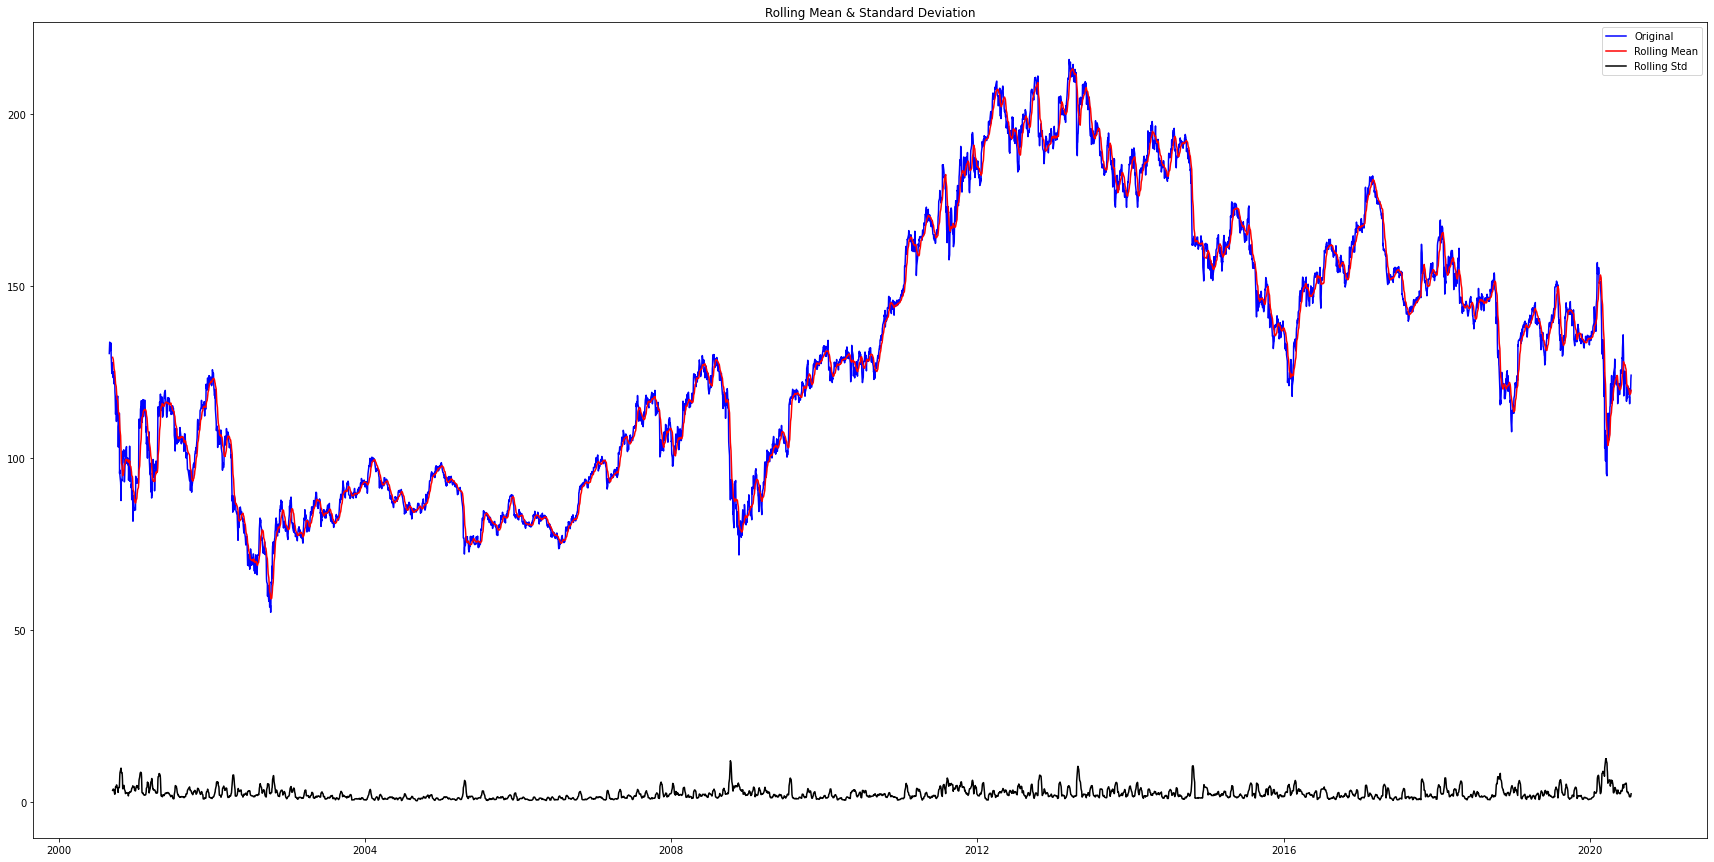

Results of Dickey-Fuller Test:
Test Statistic                   -1.511733
p-value                           0.527700
#Lags Used                       25.000000
Number of Observations Used    4974.000000
Critical Value (1%)              -3.431665
Critical Value (5%)              -2.862121
Critical Value (10%)             -2.567079
dtype: float64


In [ ]:
test_stationarity(ibm_stock_df['Close'].dropna(inplace=False))

The degree of autocorrelation is an important factor in constructing an ARIMA model. <br>
The correlation in a lag plot is a point in the ACF plot. The first autocorrelation plot uses 100 lags to determine the correlation decay. Since there is no difference in decay observed, we increase the number of lags to 1000. <br>
As we can see the second autocorrelation plot has a very slow decay. This suggests that the current stock prices are more correlated to recent values than values in the past. To better confirm the findings we need a PACF plot.<br>
A partial autocorrelation is the amount of correlation between a variable and a lag of itself that is not explained by correlations at all lower-order-lags. The PACF plot below has a significant spike at lag 1, this means that all the higher-order autocorrelations are effectively explained by the lag 1 autocorrelation. This can be a useful measure to indicate p,d,q values for our ARIMA model. <br>
However, this is not a very accurate measure as our data is not stationary.

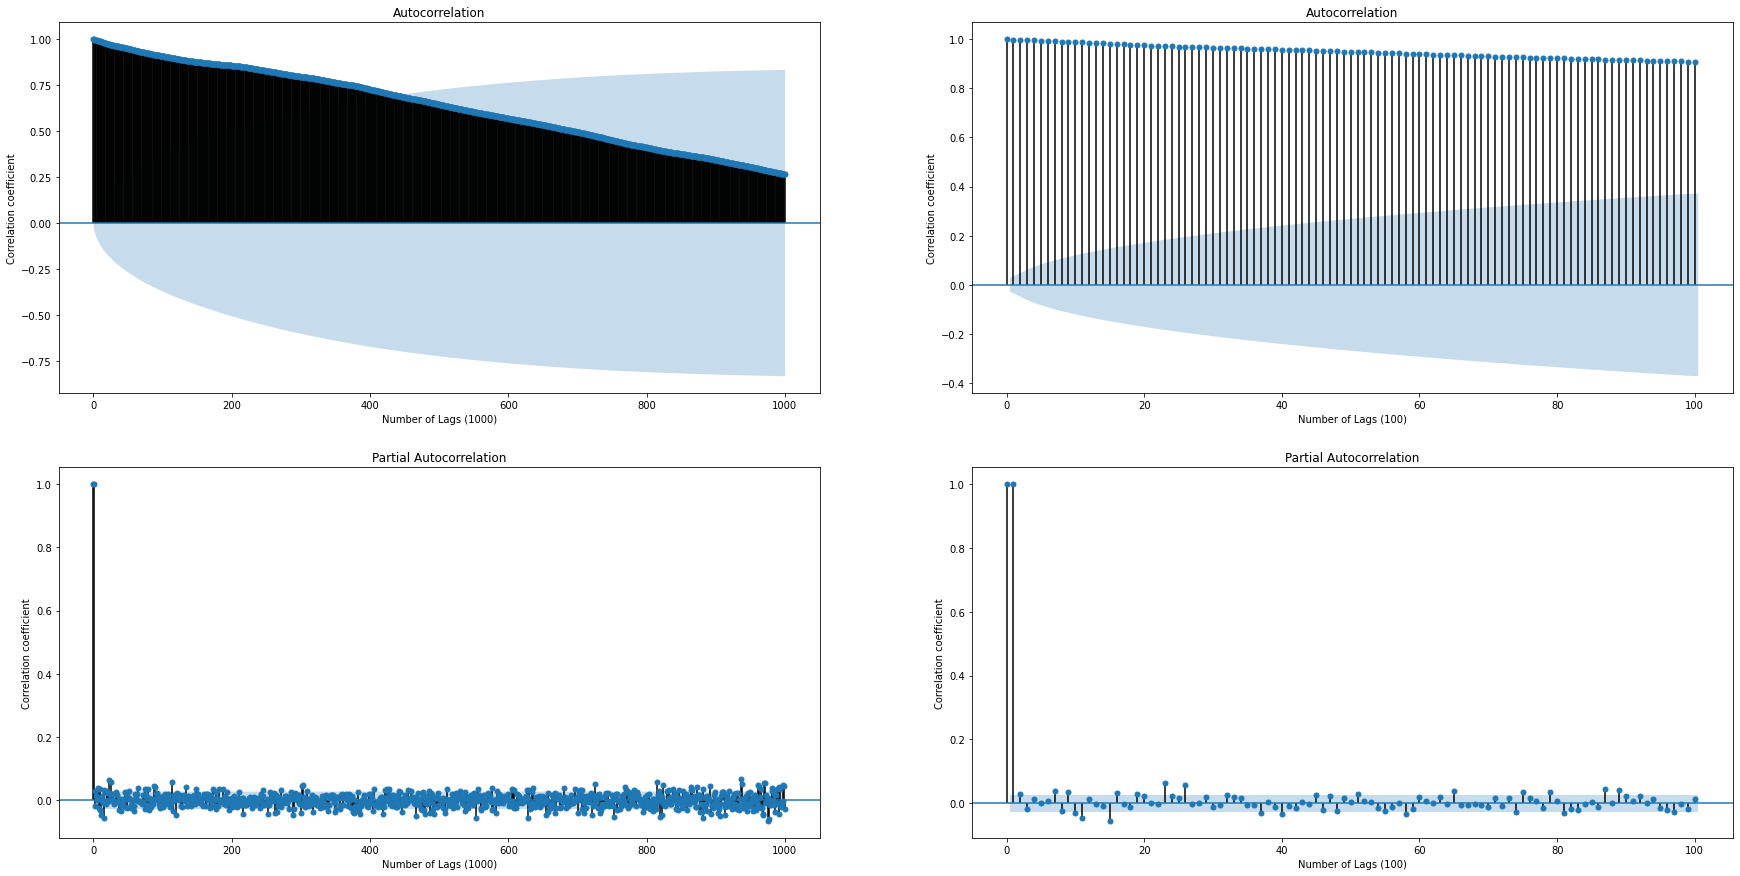

In [ ]:
non_stationary_plot('Close')

Plotting ACF and PACF on **stationary** values

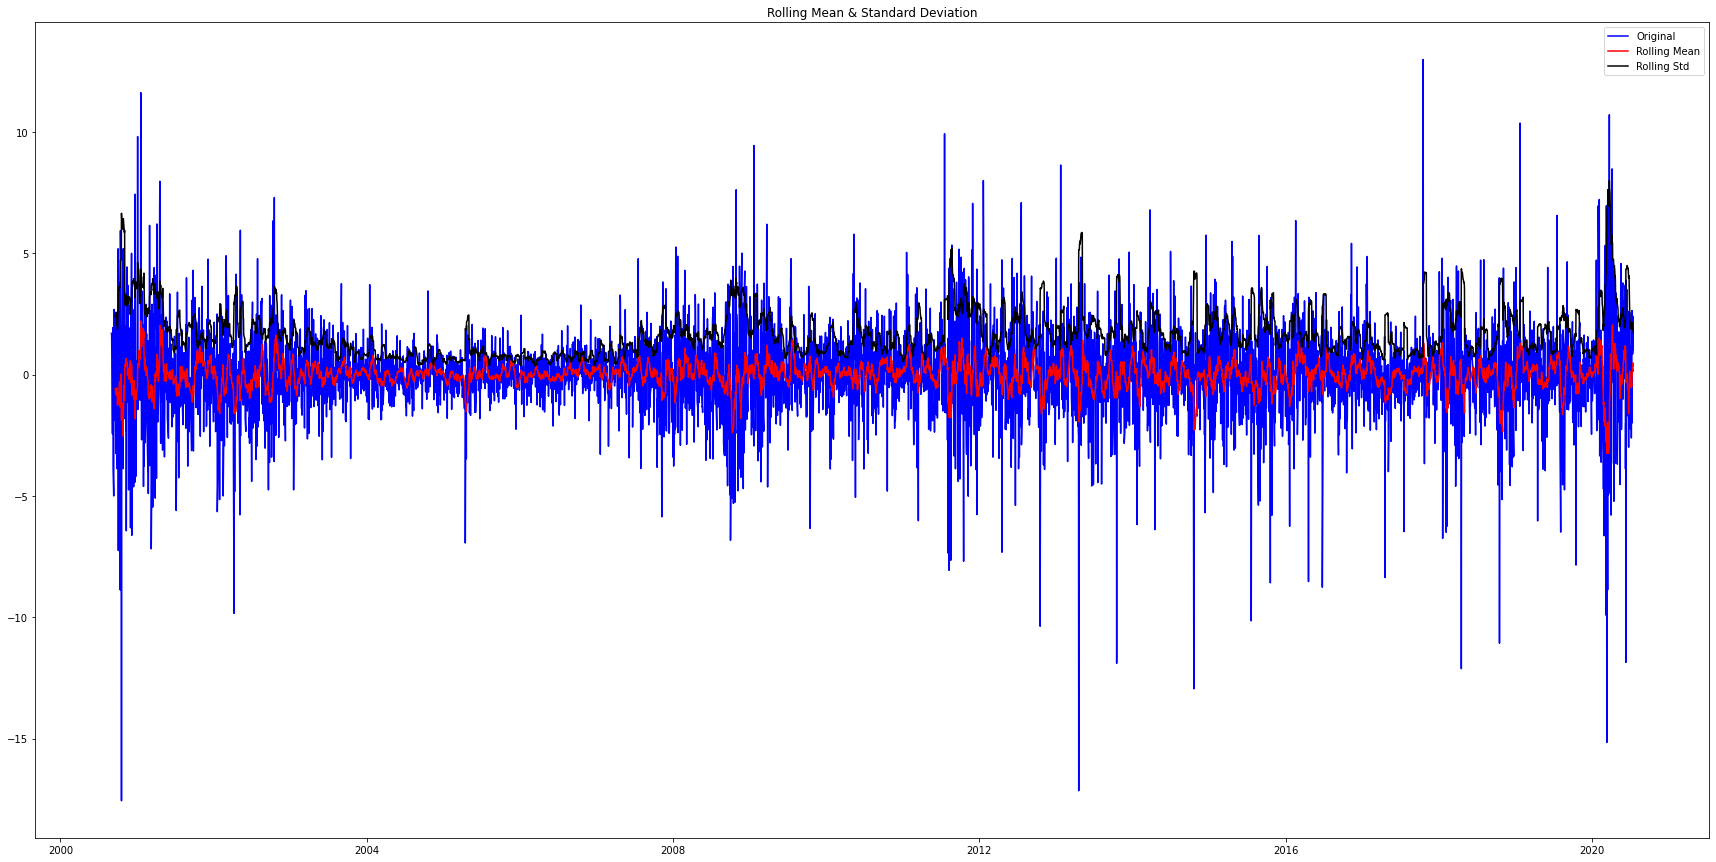

Results of Dickey-Fuller Test:
Test Statistic                -1.622809e+01
p-value                        3.836555e-29
#Lags Used                     2.400000e+01
Number of Observations Used    4.974000e+03
Critical Value (1%)           -3.431665e+00
Critical Value (5%)           -2.862121e+00
Critical Value (10%)          -2.567079e+00
dtype: float64


In [ ]:
test_stationarity((ibm_stock_df['Close'] - ibm_stock_df['Close'].shift(1)).dropna(inplace=False))

ARIMA models are required to work on stationary data to make better predictions. An uptrend or a downtrend underestimates or overestimates the mean and variance values. <br>
To convert the data to a stationary series we use the difference term (d) to calculate differences in the data columns. <br>
In the first autocorrelation plot, we use a difference of 1 on the closing stock price column. We can see that the coefficient at lag 1 is very high but after that, it's much less leading to a stationary series. <br>
As a rule of thumb if there is a significant spike in pacf plot at lag-k followed by a steep decrease in the correlation is usually an indication of an AR-1 model. <br>
The plots below suggest an ARIMA model with p-1, difference d-1, and moving average q-0.

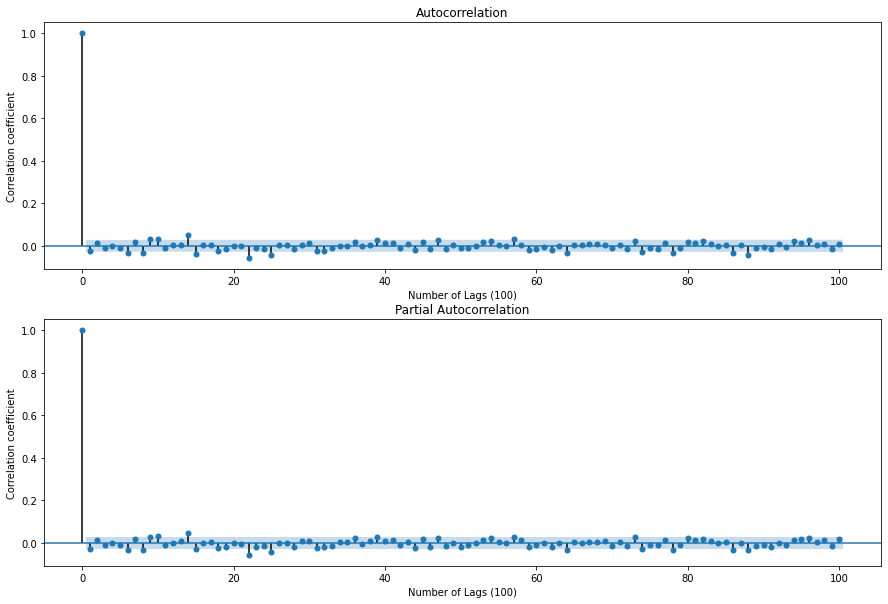

In [ ]:
stationary_plot('Close')

#### 3. Preprocess the dataset for training

In [ ]:
len(ibm_stock_df)

5000

In [ ]:
ibm_stock_df.drop_duplicates(inplace=True)
len(ibm_stock_df)

5000

In [ ]:
np.where(pd.isnull(ibm_stock_df))

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
train_data, test_data = ibm_stock_df[0:int(len(ibm_stock_df)*0.8)], ibm_stock_df[int(len(ibm_stock_df)*0.8):]

### Part II: Classical time series forecasting methods

#### 1. Choose the features and targets in the dataset.

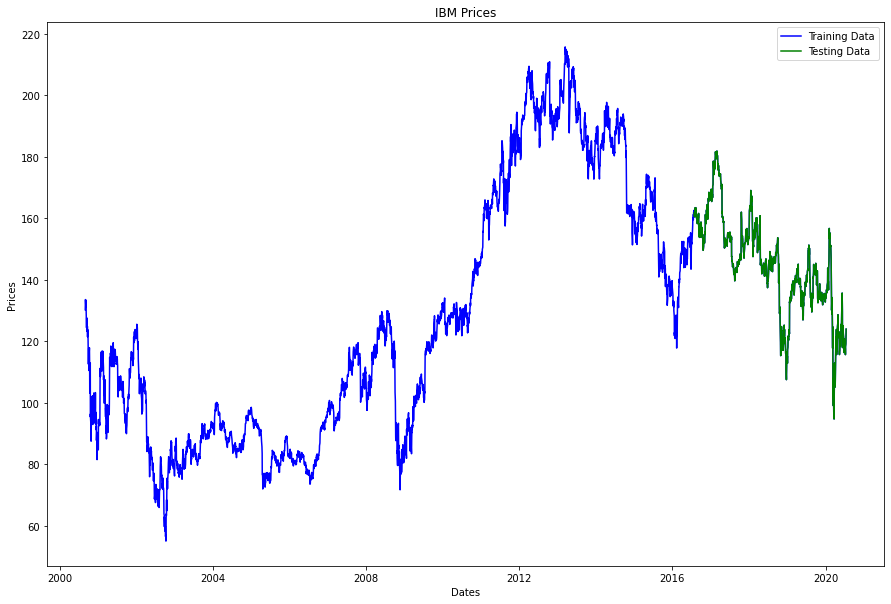

In [ ]:
plt.figure(figsize=figsize)
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(ibm_stock_df['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')
plt.legend()

#### 2. Apply statistical algorithms to forecast the values on different setups.

**Non seasonal ARIMA model (p,d,q) - Rolling forecast**

ARIMA models can give good results if applied on short time predictions. In the model below, we predict stock price data every day using the training data model and plot the difference between the actual data and test data.

In [ ]:
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

A rolling forecast can be performed by re-creating the ARIMA model for every new observation that is added.

In [ ]:
history = [x for x in train_ar]
predictions = list()

for t in range(len(test_ar)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test_ar[t])

In [ ]:
msearima = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % msearima)

Testing Mean Squared Error: 5.078


In [ ]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4998
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -10418.073
Method:                       css-mle   S.D. of innovations              1.945
Date:                Tue, 21 Jul 2020   AIC                          20842.145
Time:                        23:22:40   BIC                          20861.696
Sample:                             1   HQIC                         20848.998
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.027     -0.055      0.956      -0.054       0.051
ar.L1.D.y     -0.0263      0.014     -1.856      0.063      -0.054       0.001
                                    Roots           

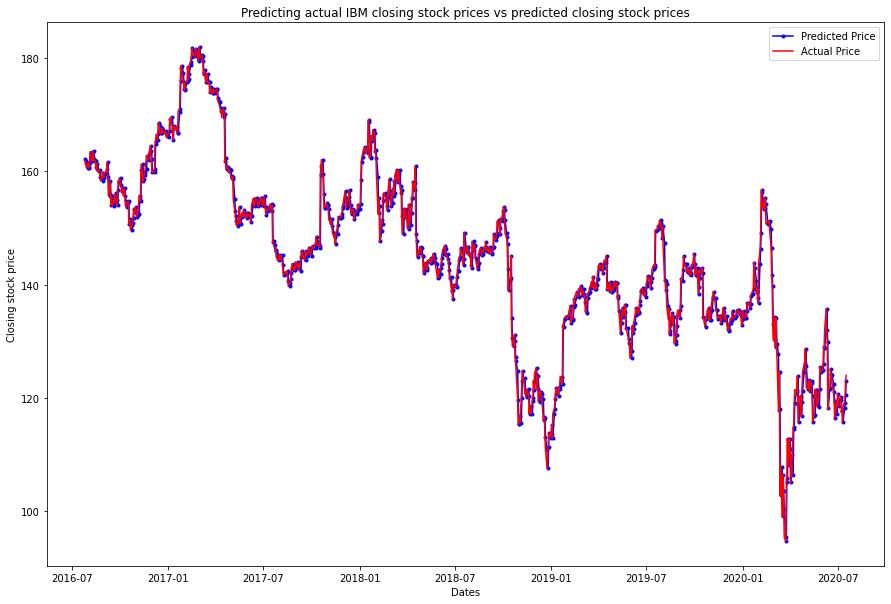

In [ ]:
plt.figure(figsize=figsize)
plt.plot(test_data.index, predictions, color='blue', marker='.', label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Non seasonal ARIMA - Rolling forecast')
plt.xlabel('Dates')
plt.ylabel('Closing stock price')
plt.legend()

**Holt Winter’s Exponential Smoothing (HWES) - Rolling forecast** <br>

Considers seasonality and trend both into account.


In [ ]:
history = [x for x in train_ar]
predictions = list()

for t in range(len(test_data)):
    model = ExponentialSmoothing(history, trend="add", seasonal="add", seasonal_periods=5)
    model_fit = model.fit()
    yhat = model_fit.forecast()
    predictions.append(yhat[0])
    history.append(test_ar[t])

In [ ]:
mseholt = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % mseholt)

Testing Mean Squared Error: 5.078


In [ ]:
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 4999
Model:             ExponentialSmoothing   SSE                          20289.600
Optimized:                         True   AIC                           7020.952
Trend:                         Additive   BIC                           7079.605
Seasonal:                      Additive   AICC                          7021.005
Seasonal Periods:                     5   Date:                 Tue, 21 Jul 2020
Box-Cox:                          False   Time:                         23:26:45
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9473688                alpha                 True
smoothing_slope          

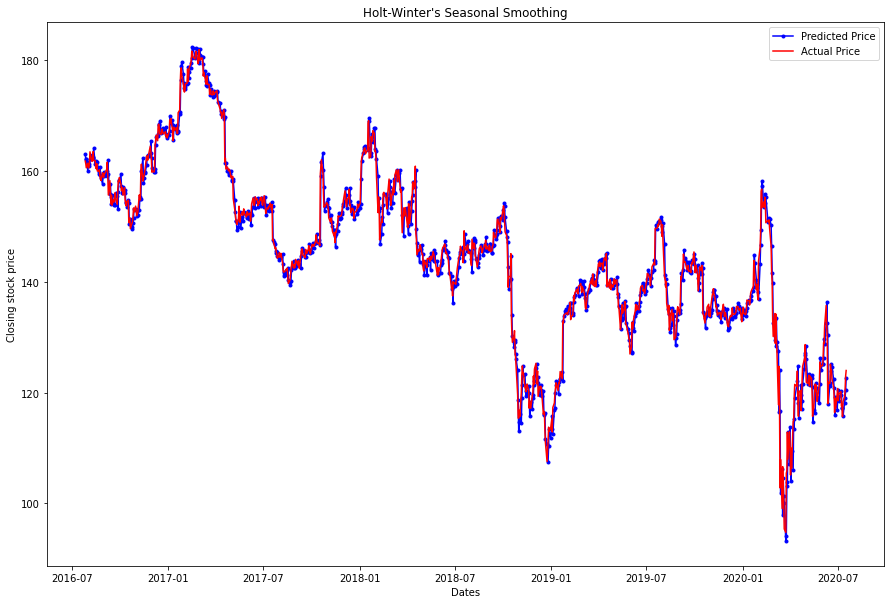

In [ ]:
plt.figure(figsize=figsize)
plt.plot(test_data.index, predictions, color='blue', marker='.', label="Predicted Price")
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title("Holt-Winter's Seasonal Smoothing - Rolling forecast")
plt.xlabel('Dates')
plt.ylabel('Closing stock price')
plt.legend()

**Seasonal ARIMA model (SARIMA)**


We aggregate our data on a monthly basis using a rolling mean and analyze the data using SARIMAX model.


In [ ]:
ibm_stock_df['MonthlyClose'] = ibm_stock_df['Close'] - ibm_stock_df['Close'].rolling(12).mean()

In [ ]:
ibm_stock_df['MonthlyClose']

Date
2000-08-30         NaN
2000-08-31         NaN
2000-09-01         NaN
2000-09-05         NaN
2000-09-06         NaN
                ...   
2020-07-10   -0.061668
2020-07-13    0.556664
2020-07-14    1.825832
2020-07-15    3.741668
2020-07-16    4.396669
Name: MonthlyClose, Length: 5000, dtype: float64

Plotting ACF and PACF on **non stationary** graph for monthly closing stock price data.

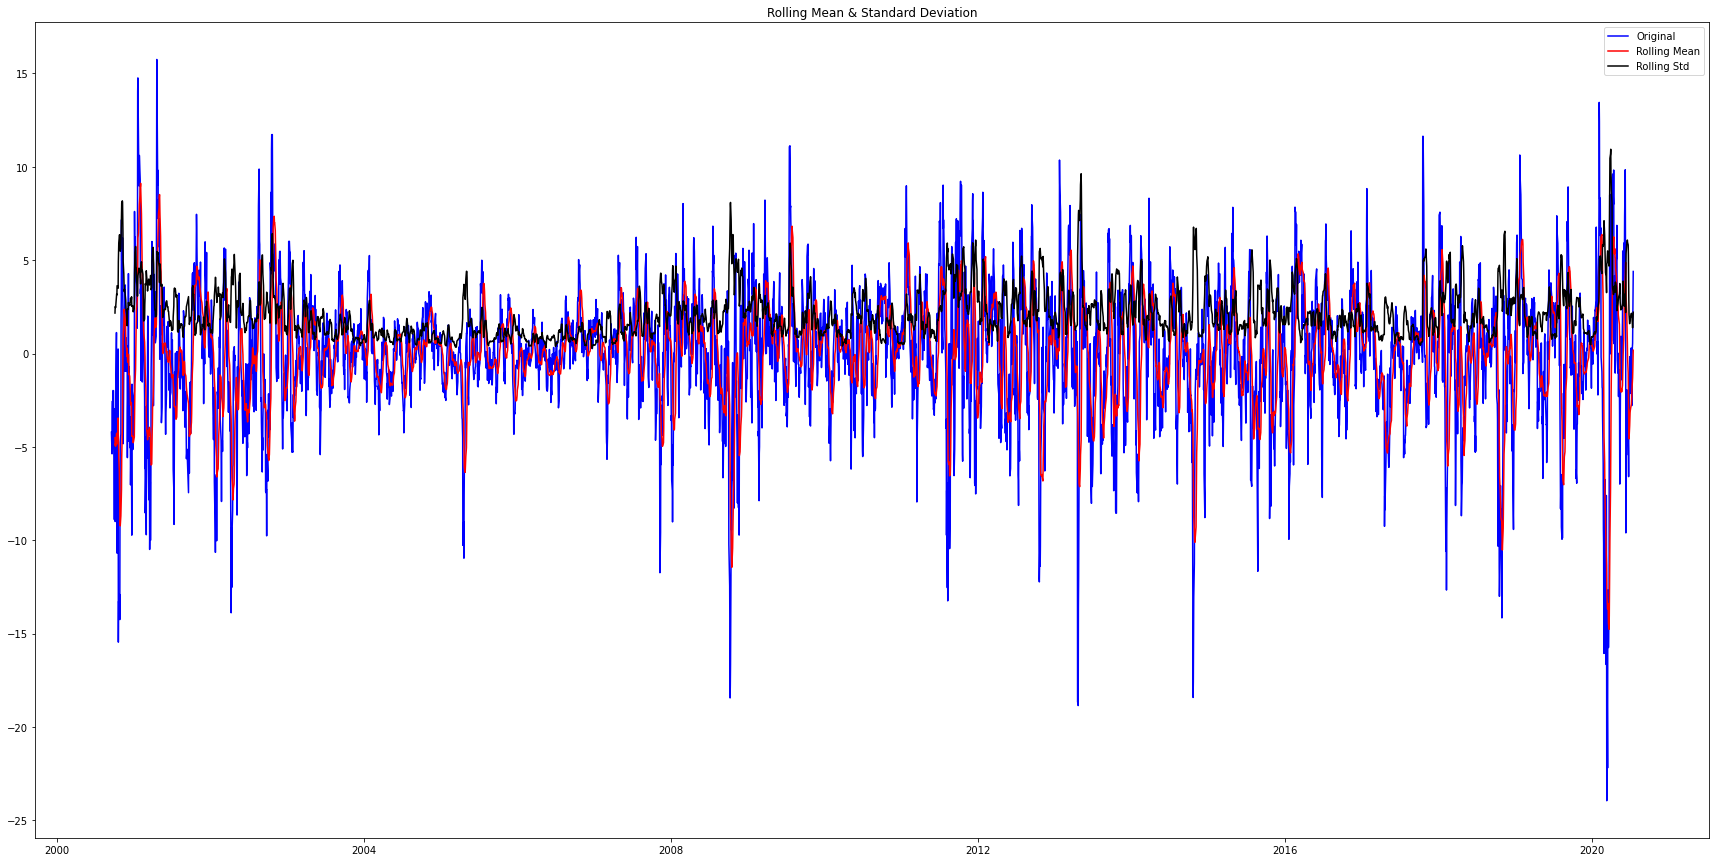

Results of Dickey-Fuller Test:
Test Statistic                -1.469090e+01
p-value                        3.050685e-27
#Lags Used                     2.200000e+01
Number of Observations Used    4.966000e+03
Critical Value (1%)           -3.431667e+00
Critical Value (5%)           -2.862122e+00
Critical Value (10%)          -2.567080e+00
dtype: float64


In [ ]:
test_stationarity(ibm_stock_df['MonthlyClose'].dropna(inplace=False))

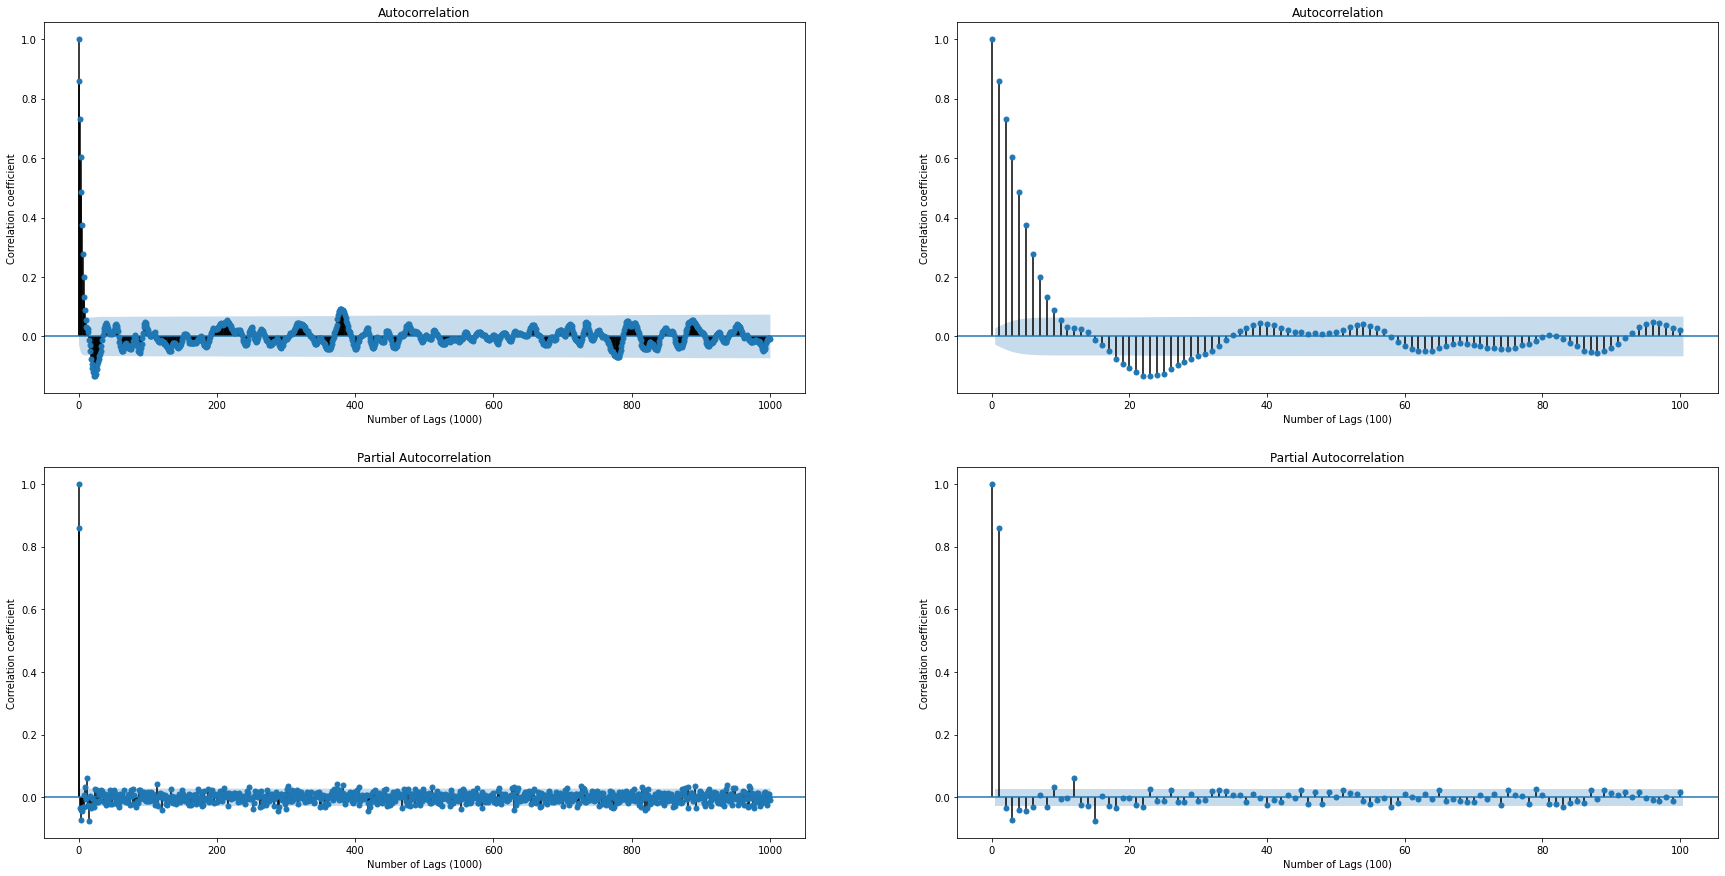

In [ ]:
non_stationary_plot('MonthlyClose')

Plotting ACF and PACF on **stationary** graph for monthly closing stock price data.

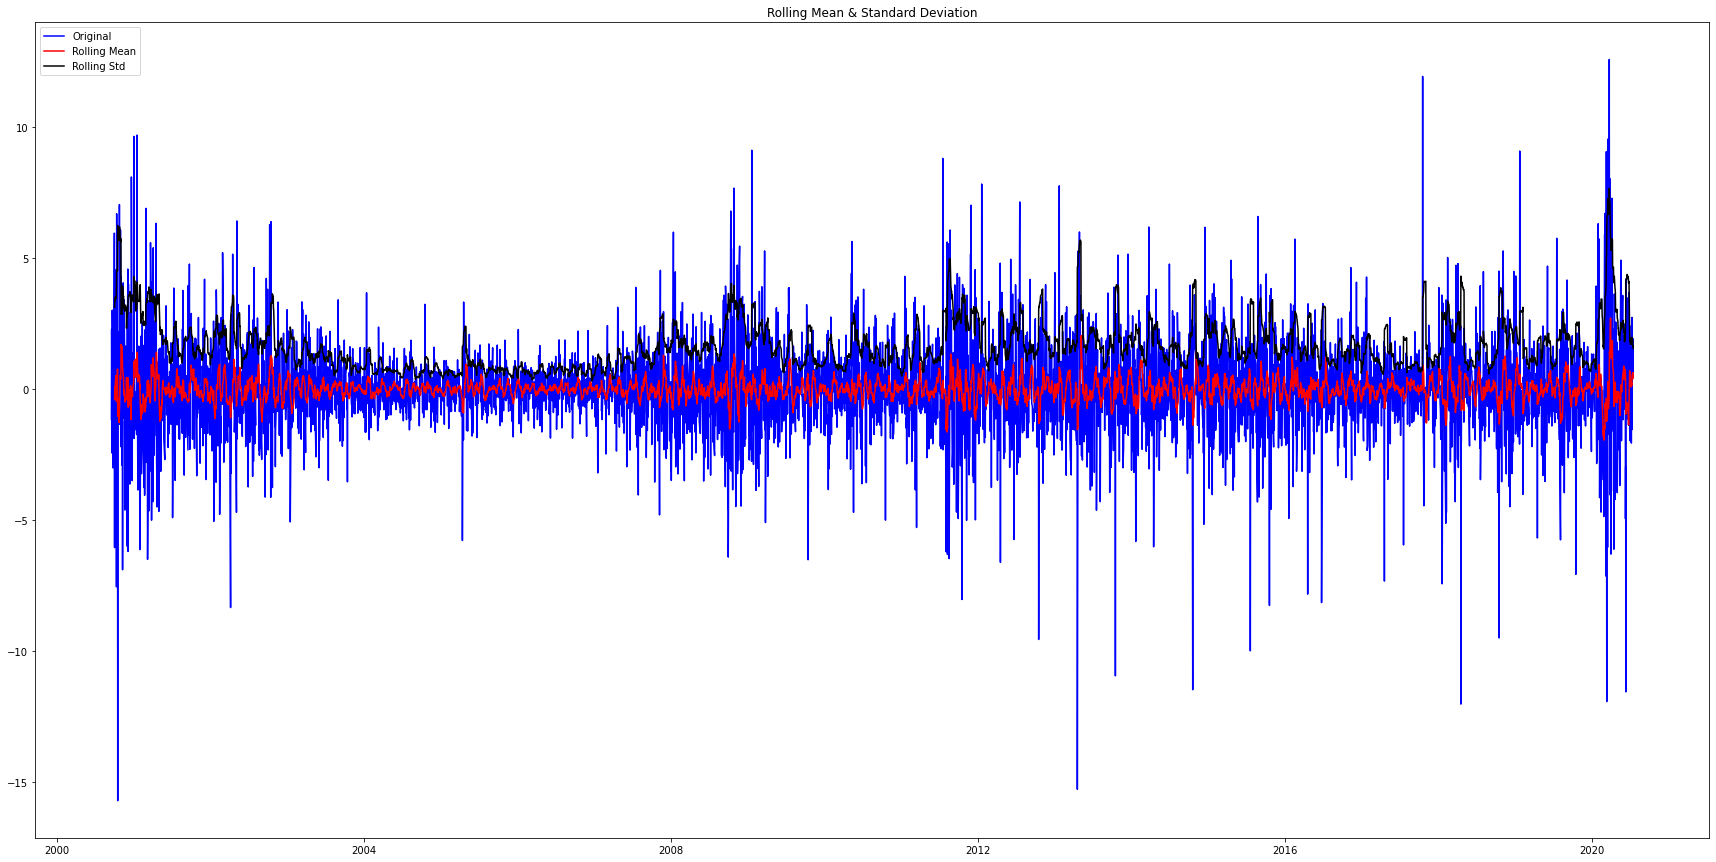

Results of Dickey-Fuller Test:
Test Statistic                  -20.897925
p-value                           0.000000
#Lags Used                       32.000000
Number of Observations Used    4955.000000
Critical Value (1%)              -3.431670
Critical Value (5%)              -2.862123
Critical Value (10%)             -2.567081
dtype: float64


In [ ]:
test_stationarity((ibm_stock_df['MonthlyClose'] - ibm_stock_df['MonthlyClose'].shift(1)).dropna(inplace=False))

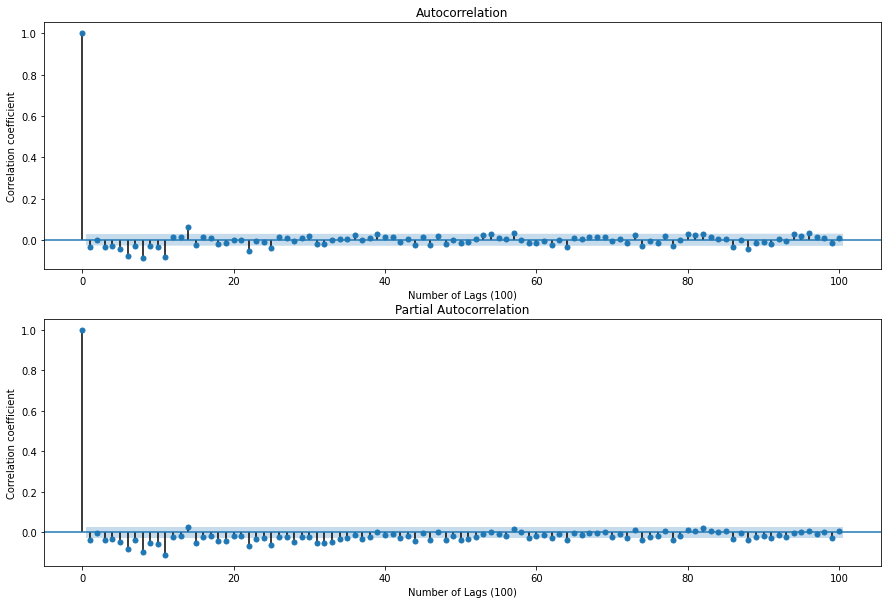

In [ ]:
stationary_plot('MonthlyClose')

In [ ]:
train_data, test_data = ibm_stock_df[0:int(len(ibm_stock_df)*0.8)], ibm_stock_df[int(len(ibm_stock_df)*0.8):]
train_ar = train_data['MonthlyClose'].values
test_ar = test_data['MonthlyClose'].values

In [ ]:
model = SARIMAX(train_ar, order=(0,1,1), seasonal_order=(0,1,1,12))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 4000
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -8095.089
Date:                            Wed, 22 Jul 2020   AIC                          16196.179
Time:                                    00:03:39   BIC                          16215.051
Sample:                                         0   HQIC                         16202.870
                                           - 4000                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0186      0.012     -1.597      0.110      -0.042       0.004
ma.S.L12      -0.9994      0.033   

In [ ]:
predictions= model_fit.predict(len(train_data), end=len(train_data)+len(test_data)-1)
msesarimax= mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % msesarimax)

Testing Mean Squared Error: 25.411


#### 3. Provide the comparison of the results of different statistical models you have used.

Explanation: As we can observe the results from the graph, we find ARIMA and Holt's method give better results than the SARIMA model. This is because the stock data for IBM is non-seasonal and it results in inaccurate predictions when the seasonality parameter is taken into account (D).

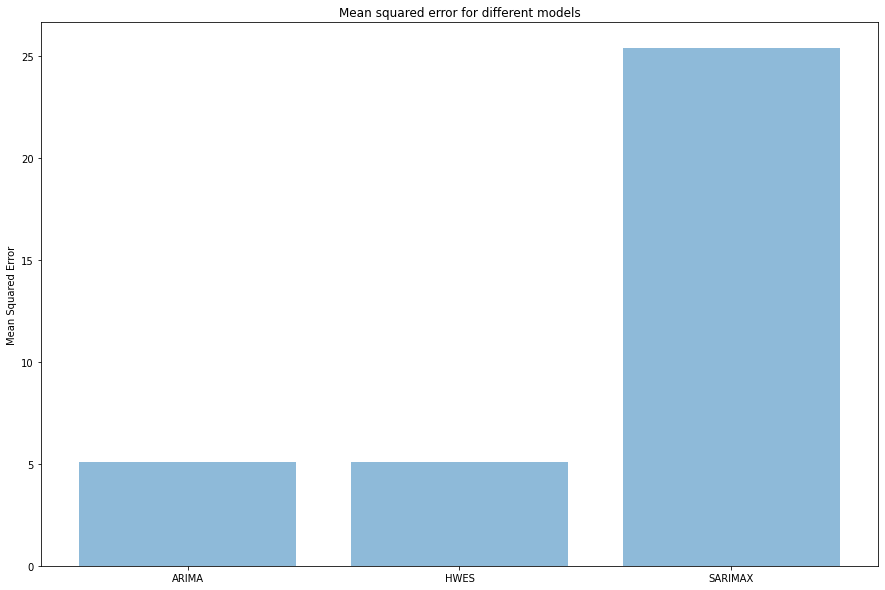

In [ ]:
objects = ('ARIMA', 'HWES', 'SARIMAX')
scores = [msearima, mseholt, msesarimax]
plt.figure(figsize=figsize)
plt.bar(objects, scores, align='center', alpha=0.5)
plt.xticks(objects)
plt.ylabel('Mean Squared Error')
plt.title('Mean squared error for different models')
plt.show()

### Part III: Deep learning time series forecasting methods

In [ ]:
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [ ]:
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = Y[0:p]
    
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
    
    X_test = X[p:]
    Y_test = y[p:]
    
    return X_train, X_test, Y_train, Y_test

In [ ]:
WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

In [ ]:
X, Y = [], []
data = ibm_stock_df.loc[:,'Close'].tolist()
for i in range(0, len(data), STEP):
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]
        
        last_close = x_i[WINDOW-1]
        next_close = y_i
        
        if last_close < next_close:
            y_i = [1 , 0]
        else: 
            y_i = [0 , 1]
            
    except Exception as e:
        print(e)
        break
        
    X.append(x_i)
    Y.append(y_i)
X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

list index out of range


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4468, 30)
(497, 30)
(4468, 2)
(497, 2)


In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, Dropout
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from keras.regularizers import l2

Using TensorFlow backend.


1. Apply MLP to predict the value. Show the results on 3 different MLP setups (#layers, activation functions, learning rate, layers structures, etc)

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=WINDOW, kernel_initializer='zeros', bias_initializer='zeros'))
model.add(Dropout(0.2))
model.add(Dense(128, input_dim=WINDOW, kernel_initializer='zeros', bias_initializer='zeros'))
model.add(Dropout(0.2))
model.add(Dense(128, input_dim=WINDOW, kernel_initializer='zeros', bias_initializer='zeros'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = Adam()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               3968      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)              

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                   epochs=100,
                   batch_size=64,
                   verbose=1,
                   validation_data=(X_test, Y_test),
                   shuffle=True,callbacks=[reduce_lr])

Epoch 1/100
70/70 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.5049 - val_loss: 0.6909 - val_accuracy: 0.5453 - lr: 0.0010
Epoch 2/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5215 - val_loss: 0.6911 - val_accuracy: 0.5453 - lr: 0.0010
Epoch 3/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5197 - val_loss: 0.6925 - val_accuracy: 0.5453 - lr: 0.0010
Epoch 4/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.5031 - val_loss: 0.6907 - val_accuracy: 0.5453 - lr: 0.0010
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5076 - val_loss: 0.6902 - val_accuracy: 0.5453 - lr: 0.0010
Epoch 6/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5056 - val_loss: 0.6954 - val_accuracy: 0.4547 - lr: 0.0010
Epoch 7/100
70/70 [==============================] - 0s 4ms/step - loss: 0.6

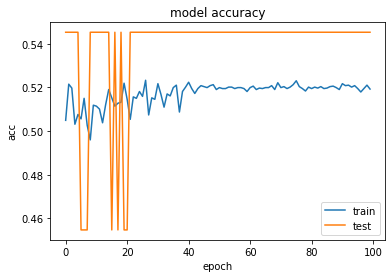

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

In the above model, kernel weights and bias values are initialized with zeros. The equations in the learning algorithm failed to make any changes to the network weights and hence the model is stuck. The valudation accuracy of the doesn't change even as the training progresses.

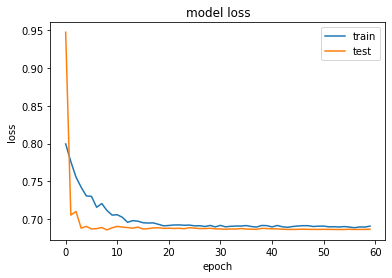

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

In [ ]:
model2 = Sequential()
model2.add(Dense(128, input_dim=WINDOW))
model2.add(Dropout(0.4))
model2.add(Dense(128, input_dim=WINDOW))
model2.add(Dropout(0.4))
model2.add(BatchNormalization())
model2.add(LeakyReLU())
model2.add(Dense(2))
model2.add(Activation('softmax'))

optimizer = Adam()
model2.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 128)               3968      
_________________________________________________________________
dropout_92 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_153 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_93 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_154 (Dense)            (None, 2)               

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model2.fit(X_train, Y_train,
                   epochs=150,
                   batch_size=128,
                   verbose=1,
                   validation_data=(X_test, Y_test),
                   shuffle=True,callbacks=[reduce_lr])

Epoch 1/150
35/35 [==============================] - 0s 7ms/step - loss: 0.8523 - accuracy: 0.5022 - val_loss: 0.7095 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 2/150
35/35 [==============================] - 0s 4ms/step - loss: 0.7785 - accuracy: 0.5065 - val_loss: 0.6890 - val_accuracy: 0.5453 - lr: 0.0010
Epoch 3/150
35/35 [==============================] - 0s 5ms/step - loss: 0.7439 - accuracy: 0.5114 - val_loss: 0.6932 - val_accuracy: 0.5473 - lr: 0.0010
Epoch 4/150
35/35 [==============================] - 0s 4ms/step - loss: 0.7445 - accuracy: 0.5029 - val_loss: 0.6940 - val_accuracy: 0.5091 - lr: 0.0010
Epoch 5/150
35/35 [==============================] - 0s 4ms/step - loss: 0.7321 - accuracy: 0.5060 - val_loss: 0.6902 - val_accuracy: 0.5252 - lr: 0.0010
Epoch 6/150
35/35 [==============================] - 0s 4ms/step - loss: 0.7216 - accuracy: 0.5130 - val_loss: 0.6945 - val_accuracy: 0.5151 - lr: 0.0010
Epoch 7/150
17/35 [=============>................] - ETA: 0s - loss: 0.7158 

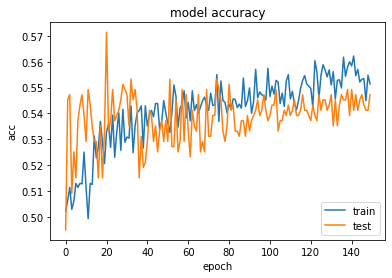

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

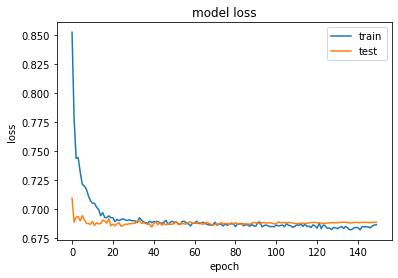

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

In the model above, kernel weights, bias and activation functions are left to default, with 128 nodes in two layer with 150 epochs for the network. Final test accuracy of the model is **54.73**%.

In [ ]:
model3 = Sequential()
model3.add(Dense(128, input_dim=WINDOW, kernel_initializer='he_uniform', bias_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(ReLU())
model3.add(Dropout(0.3))
model3.add(Dense(64, input_dim=WINDOW, kernel_initializer='he_uniform', bias_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(ReLU())
model3.add(Dropout(0.3))
model3.add(BatchNormalization())
model3.add(LeakyReLU())
model3.add(Dense(2))
model3.add(Activation('softmax'))

optimizer = Adam()
model3.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 128)               3968      
_________________________________________________________________
dropout_94 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_156 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_95 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 64)                256       
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_157 (Dense)            (None, 2)               

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
model3.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model3.fit(X_train, Y_train,
                   epochs=150,
                   batch_size=128,
                   verbose=1,
                   validation_data=(X_test, Y_test),
                   shuffle=True,callbacks=[reduce_lr])

Epoch 1/150
35/35 [==============================] - 0s 7ms/step - loss: 0.7984 - accuracy: 0.5047 - val_loss: 0.7099 - val_accuracy: 0.5191 - lr: 0.0010
Epoch 2/150
35/35 [==============================] - 0s 4ms/step - loss: 0.7490 - accuracy: 0.5130 - val_loss: 0.6902 - val_accuracy: 0.5453 - lr: 0.0010
Epoch 3/150
35/35 [==============================] - 0s 4ms/step - loss: 0.7487 - accuracy: 0.5025 - val_loss: 0.6863 - val_accuracy: 0.5473 - lr: 0.0010
Epoch 4/150
35/35 [==============================] - 0s 4ms/step - loss: 0.7350 - accuracy: 0.5119 - val_loss: 0.6889 - val_accuracy: 0.5634 - lr: 0.0010
Epoch 5/150
35/35 [==============================] - 0s 4ms/step - loss: 0.7200 - accuracy: 0.5161 - val_loss: 0.6856 - val_accuracy: 0.5634 - lr: 0.0010
Epoch 6/150
35/35 [==============================] - 0s 4ms/step - loss: 0.7150 - accuracy: 0.5181 - val_loss: 0.6831 - val_accuracy: 0.5634 - lr: 0.0010
Epoch 7/150
35/35 [==============================] - 0s 4ms/step - loss: 0.7

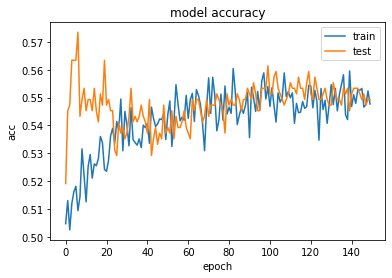

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

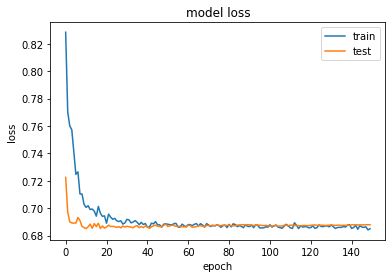

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

In the above network, the kernel weights and bias are initialalized with **he normal** scheme, where in the mean of the initial weights will be zero. As the training progresses, the accuracy of both train and test set increased, without overfitting for 150 epochs with a batch size of 128. Final test accuracy is **54.93**%

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4468, 30, 1)
(497, 30, 1)
(4468, 2)
(497, 2)


2. Apply RNN or LSTM architecture to predict the value.

In [ ]:
model6 = Sequential()
model6.add(LSTM(units = 32, input_shape = (X_train.shape[1], 1), return_sequences = True))
model6.add(Dropout(0.3))
model6.add(LSTM(units = 16, return_sequences = True))
model6.add(Flatten())
model6.add(Dense(units=2, activation = "softmax"))
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
model6.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model6.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 30, 32)            4352      
_________________________________________________________________
dropout_116 (Dropout)        (None, 30, 32)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 30, 16)            3136      
_________________________________________________________________
flatten_14 (Flatten)         (None, 480)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 2)                 962       
Total params: 8,450
Trainable params: 8,450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model6.fit(X_train, Y_train,
                   epochs=100,
                   batch_size=64,
                   verbose=1,
                   validation_data=(X_test, Y_test), 
                    callbacks=[reduce_lr])

Epoch 1/100
70/70 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5184 - val_loss: 0.6847 - val_accuracy: 0.5533 - lr: 0.0010
Epoch 2/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5309 - val_loss: 0.6830 - val_accuracy: 0.5594 - lr: 0.0010
Epoch 3/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6908 - accuracy: 0.5354 - val_loss: 0.6849 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 4/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5251 - val_loss: 0.6855 - val_accuracy: 0.5594 - lr: 0.0010
Epoch 5/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5316 - val_loss: 0.6835 - val_accuracy: 0.5594 - lr: 0.0010
Epoch 6/100
70/70 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.5304 - val_loss: 0.6848 - val_accuracy: 0.5513 - lr: 0.0010
Epoch 7/100
67/70 [===========================>..] - ETA: 0s - loss: 0.6900

The LSTM model given above gives the highest accuracy among all the models trained so far with **57.34**% . This model has 32 nodes in the first layer and 16 nodes in the second one, with *adam* optimizer and *categorical cross entropy* loss.

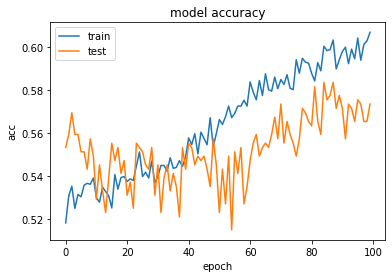

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

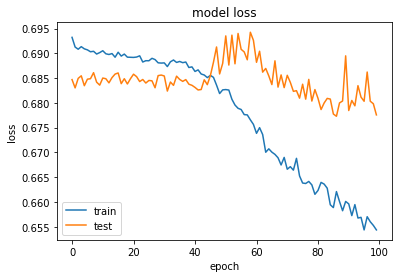

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

The method above is trained only to predict if the stock price of the next day goes up or down. It is a classification problem. Then neext approach gives the regression analysis, which predicts the stock price of the next day, where LSTM with one layer is used with 16 nodes.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
train_data, test_data = ibm_stock_df[0:int(len(ibm_stock_df)*0.8)], ibm_stock_df[int(len(ibm_stock_df)*0.8):]

In [ ]:
train_data = train_data['Close'].values.reshape(-1,1)
test_data = test_data['Close'].values.reshape(-1,1)

In [ ]:
train_data = scaler.fit_transform(train_data)


In [ ]:
x_train = train_data[:-1]
y_train = train_data[1:]


In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, 1))

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units = 16, activation = 'relu', input_shape = (None, 1)))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
lstm_model.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 16)                1152      
_________________________________________________________________
dense_175 (Dense)            (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm_model.fit(x_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
125/125 [==============================] - 1s 4ms/step - loss: 0.1531
Epoch 2/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0398
Epoch 3/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0211
Epoch 4/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0143
Epoch 5/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 6/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 7/50
125/125 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 8/50
125/125 [==============================] - 0s 4ms/step - loss: 8.8132e-04
Epoch 9/50
125/125 [==============================] - 0s 4ms/step - loss: 5.3831e-04
Epoch 10/50
125/125 [==============================] - 0s 4ms/step - loss: 4.5132e-04
Epoch 11/50
125/125 [==============================] - 0s 4ms/step - loss: 4.3160e-04
Epoch 12/50
125/125 [==============================] - 0s 4ms/step - loss: 4.2607e-04
Epoch

In [ ]:
ip = test_data
test_data = scaler.transform(test_data)
test = np.reshape(test_data, (test_data.shape[0],1,1))
preds = lstm_model.predict(test)

In [ ]:
preds = scaler.inverse_transform(preds)

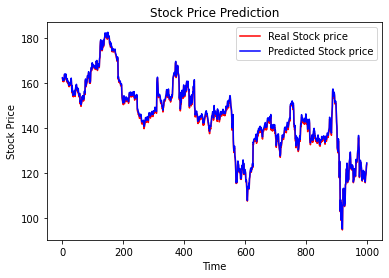

In [ ]:
plt.plot(ip, color = 'red', label = 'Real Stock price')
plt.plot(preds, color = 'blue', label = 'Predicted Stock price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(ip, preds))
print("RMSE for LSTM: ", rmse)

RMSE for LSTM:  0.7333519854506497


### References

##### *Datasets*
1. https://finance.yahoo.com/quote/IBM/history?period1=-223603200&period2=1595030400&interval=1d&filter=history&frequency=1d

##### *Code*
1. https://stackoverflow.com/a/27159258/6379722
2. https://stackoverflow.com/a/11404223/6379722
3. https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
4. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
5. https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

##### *Readings*
1. https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775
2. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
3. https://finance.zacks.com/adjusted-closing-price-vs-closing-price-9991.html
4. http://people.duke.edu/~rnau/411arim3.htm
5. https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/
6. https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html
7. https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404
8. https://www.quora.com/How-can-I-explain-the-fact-that-test-accuracy-is-much-higher-than-train-accuracy